<a href="https://colab.research.google.com/github/zhiyuan-95/House-Prices/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## get ready

In [1]:
%%shell
pip --quiet install kaggle

In [2]:
from google.colab import files
# Upload the kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"empanadas","key":"5fed06c3ff0bb75c2967ced0f6e33e00"}'}

In [3]:
!mkdir /root/.kaggle/
!cp kaggle.json /root/.kaggle/

In [4]:
import subprocess
api_command = 'kaggle competitions download -c house-prices-advanced-regression-techniques'
subprocess.run(api_command, shell = True)

CompletedProcess(args='kaggle competitions download -c house-prices-advanced-regression-techniques', returncode=0)

In [5]:
import zipfile
with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip','r') as zip_ref:
  zip_ref.extractall('/content')

## data exploration

In [6]:
import pandas as pd
df = pd.read_csv('train.csv')
df.index = df.Id
df = df.drop(columns = ['Id'])
test = pd.read_csv('test.csv')
test = test.drop(columns = ['Id'])
#df.shape
#df.head()

In [7]:
df_info = pd.DataFrame()
items = []
for x in df.columns:
  items.append({'column':x, 'Non-Null count': df[x].count(), 'Dtype': df[x].dtype})
dfs = [pd.DataFrame([item]) for item in items]
df_info = pd.concat(dfs, ignore_index=True)
df_info

,column,Non-Null count,Dtype
0,MSSubClass,1460,int64
1,MSZoning,1460,object
2,LotFrontage,1201,float64
3,LotArea,1460,int64
4,Street,1460,object
...,...,...,...
75,MoSold,1460,int64
76,YrSold,1460,int64
77,SaleType,1460,object
78,SaleCondition,1460,object


### numerical data preperation

In [8]:
num = list(df_info.loc[(df_info.Dtype=='int64') | (df_info.Dtype=='float64')].column)
cat = list(df_info.loc[df_info.Dtype=='object'].column)


In [9]:
#fillna with median for numerical columns
def fillna_num(df):
  return df[num].fillna(df[num].median())

In [10]:
df[num] = fillna_num(df)

In [11]:
most_relevent_num = pd.DataFrame(df[num].corr()['SalePrice']).abs().sort_values(['SalePrice'],ascending=False).index

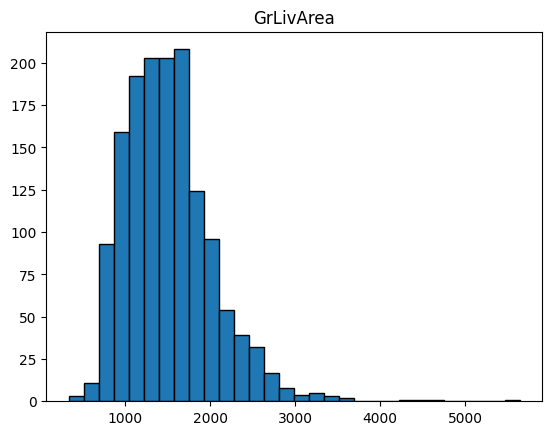

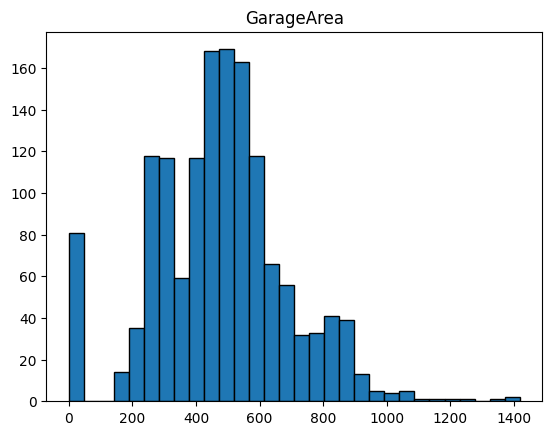

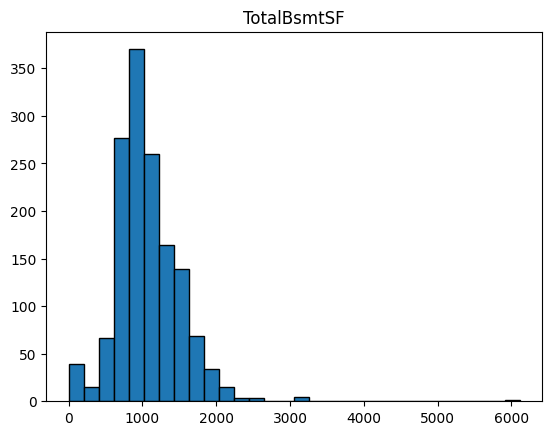

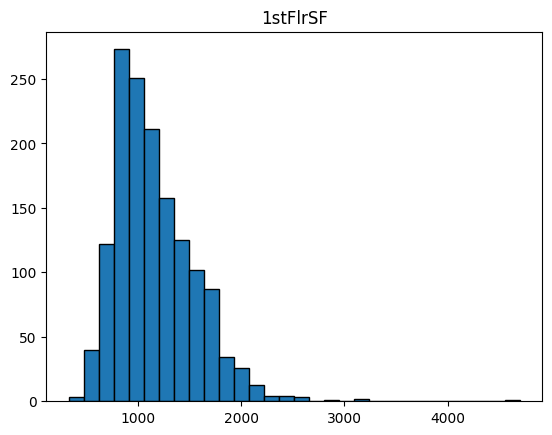

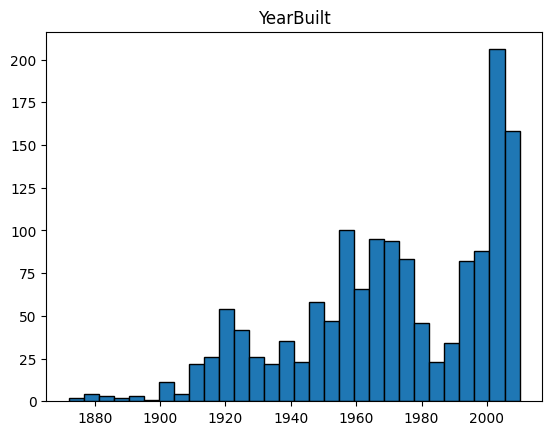

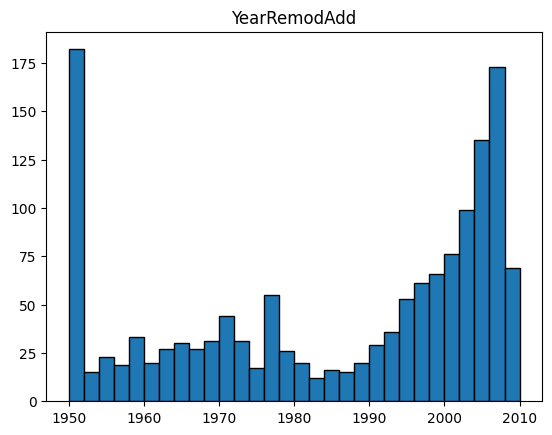

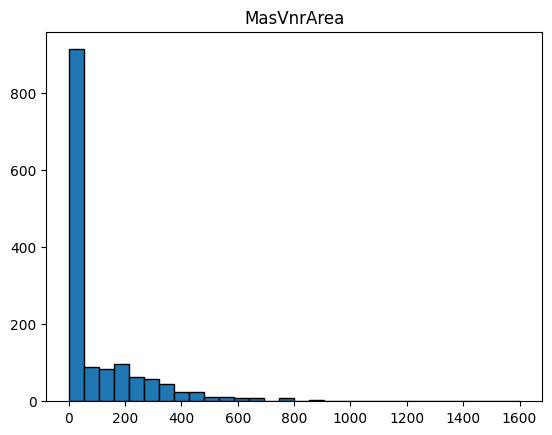

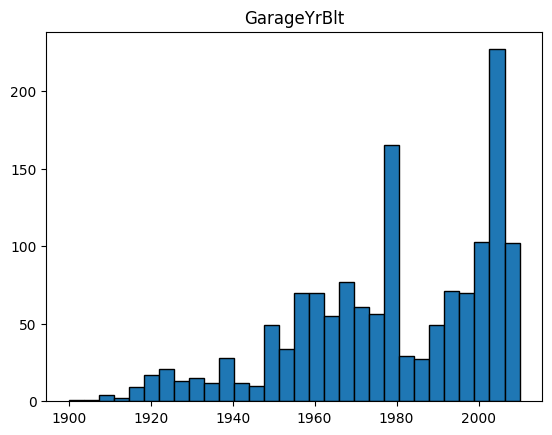

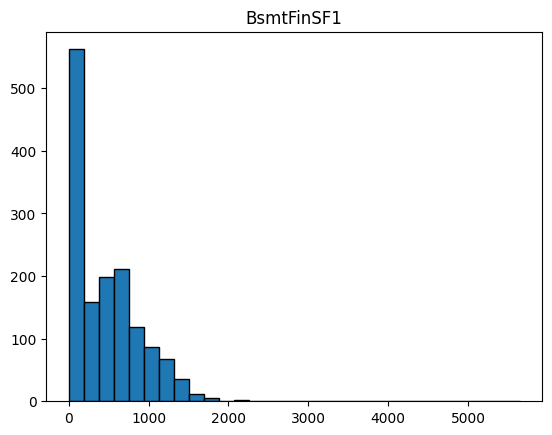

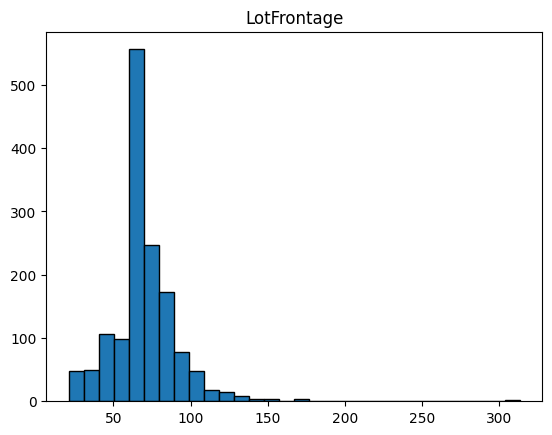

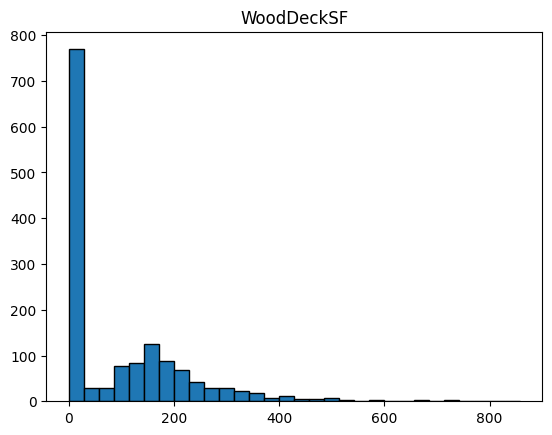

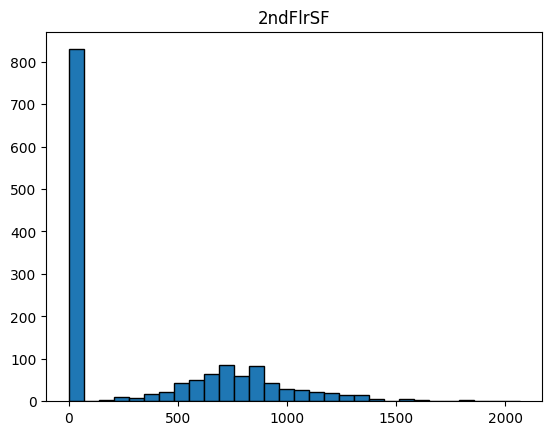

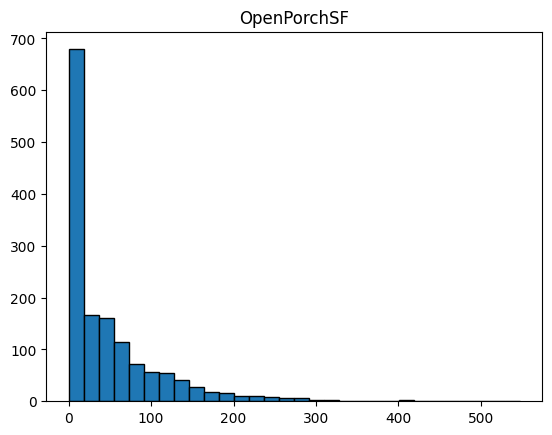

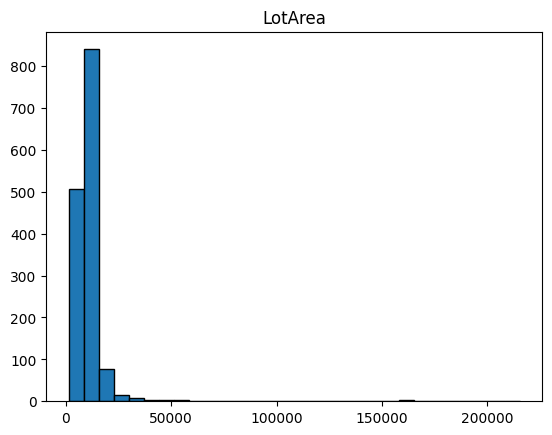

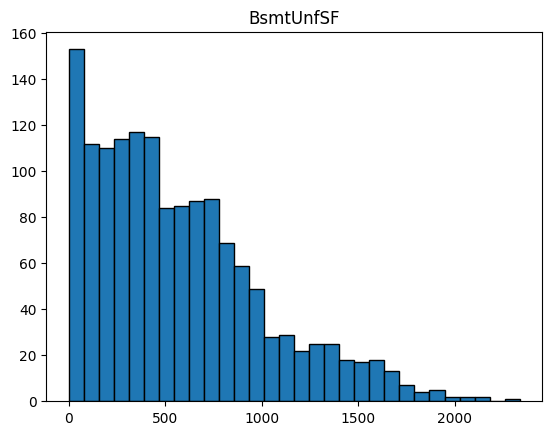

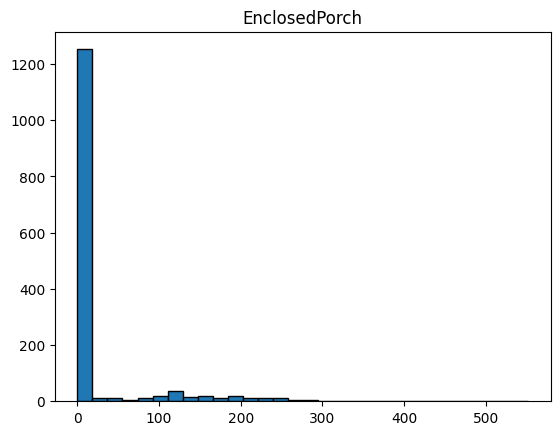

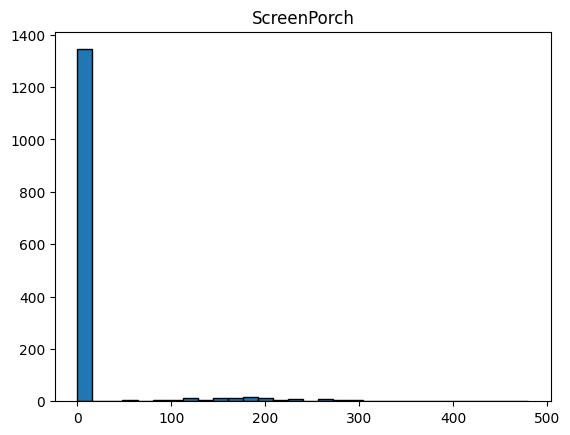

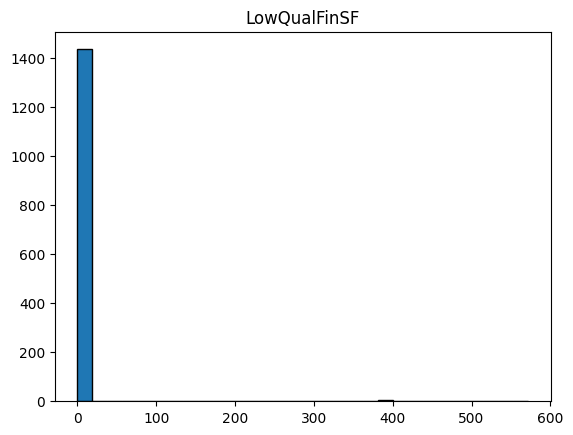

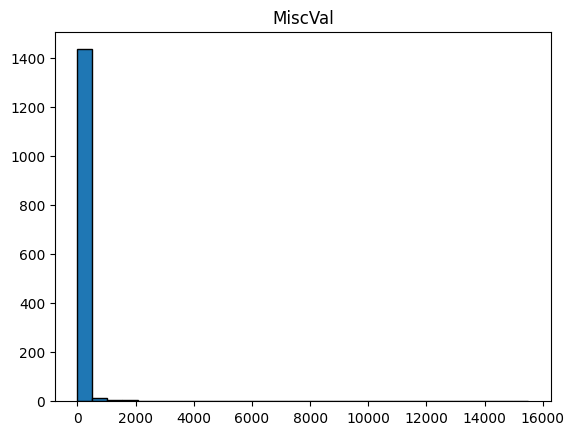

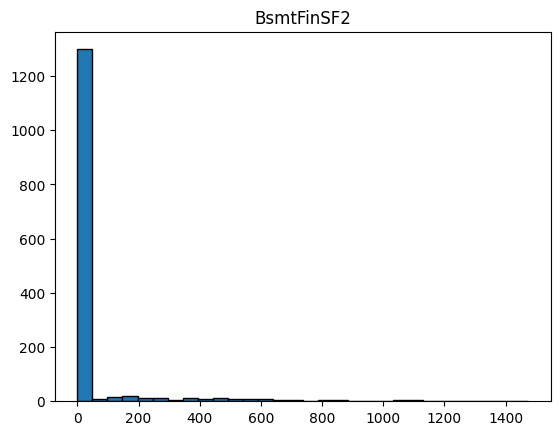

In [12]:
import matplotlib.pyplot as plt
for x in most_relevent_num[1:]:
  l =len(df[x].value_counts().index)
  if l>20:
    plt.hist(df[x], bins = 30, edgecolor = 'k')
    plt.title(x)
    plt.show()

In [13]:
#remove outliers of GrliveArea,GrageArea,TotalBasmtSF,1stFlrSF,BsmtFinSF1
# I only removed upper bound, because lower bound is zero.
def num_extrem_remover(df):
  for x in ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','BsmtFinSF1']:
    upper_bound = df[x].quantile(0.995)
  return df.loc[df[x]<upper_bound]

In [14]:
df = num_extrem_remover(df)
num = num[:-1]
test[num] = fillna_num(test)

In [15]:
test.shape

(1459, 79)

### categorical data preperation

categorical data fillna

In [16]:
def fillna_cat(df):
  return df[cat].fillna('None')

In [17]:
df.loc[:,cat] = fillna_cat(df)
test.loc[:,cat] = fillna_cat(test)
combined_df = pd.concat([df[cat[:-1]],test[cat]], axis = 0)

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
encoder = OneHotEncoder()
cat_encoded = encoder.fit_transform(combined_df[cat])
hot_feature = encoder.get_feature_names_out()

In [20]:
train_expanded_cat = pd.DataFrame(cat_encoded[:len(df)].toarray(), columns = hot_feature, index = df.index)
test_expanded_cat =  pd.DataFrame(cat_encoded[len(df):].toarray(), columns = hot_feature, index = test.index)

In [21]:
train_encoded = pd.concat([df,train_expanded_cat], axis = 1)
test_encoded = pd.concat([test,test_expanded_cat],axis = 1)
train_encoded = train_encoded.drop(columns = cat)
test_encoded = test_encoded.drop(columns=cat)

In [22]:
test_encoded.shape

(1459, 310)

### Identify Additional Predictive Feature

Based on our experience, the total area of the house and the average area per room should also be important factors in determining the price. Please create these two columns using the following formula:

1.   total area = total area above ground (“GrLivArea”) + total basement area (“TotalBsmtSF”)
2.   area per room = total area above ground (“GrLivArea”) / number of rooms (“TotRmsAbvGrd”).
3. lot&garage = 0.006*lot area +GarageArea
4. MVTA = correlation of different type of  Masonry veneer type * area of  Masonry veneer with that type

In [23]:
import numpy as np

In [24]:
MVT = train_encoded[list(filter(lambda x: x[:10]=='MasVnrType',hot_feature))].columns
MVT_corr = pd.concat([train_encoded[MVT],train_encoded['SalePrice']], axis = 1).corr()['SalePrice']
MV_area_train = np.sum(train_encoded[MVT].to_numpy()*MVT_corr.to_numpy()[:-1],axis = 1)*train_encoded['MasVnrArea'].to_numpy()
MV_area_test = np.sum(test_encoded[MVT].to_numpy()*MVT_corr.to_numpy()[:-1],axis = 1)*test_encoded['MasVnrArea'].to_numpy()

In [25]:
train_encoded['total_area'] = train_encoded.apply(lambda x:x['GrLivArea']+x['TotalBsmtSF'], axis=1)
train_encoded['Area per room'] = train_encoded.apply(lambda x:x['GrLivArea']/x['TotRmsAbvGrd'], axis=1)
train_encoded['lot&Garage'] = train_encoded.apply(lambda x:0.006*x['LotArea']+x['GarageArea'], axis=1)
train_encoded['MVTA'] = pd.DataFrame(MV_area_train, index = train_encoded.index)

In [26]:
test_encoded['total_area'] = test_encoded.apply(lambda x:x['GrLivArea']+x['TotalBsmtSF'], axis=1)
test_encoded['Area per room'] = test_encoded.apply(lambda x:x['GrLivArea']/x['TotRmsAbvGrd'], axis=1)
test_encoded['lot&Garage'] = test_encoded.apply(lambda x:0.006*x['LotArea']+x['GarageArea'], axis=1)
test_encoded['MVTA'] = pd.DataFrame(MV_area_test, index=test_encoded.index)

## build a optimizer

In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import os
import time

In [29]:
class optimizer:
  def __init__(self, model):
    self._model = model()
    self._model_name = type(self._model).__name__
    self._model_params = self._model._get_param_names()
  def update_record(self,params,score):
    records = pd.read_csv(f'/content/drive/MyDrive/Colab/kaggle/HousePrices/{self._model_name}.csv')
    records.loc[len(records)] = params
    records.loc[len(records)-1,'score'] = score
    records.to_csv(f'/content/drive/MyDrive/Colab/kaggle/HousePrices/{self._model_name}.csv', index = False)
  def reset(self):
    df = pd.DataFrame(columns = self._model_params+['score'])
    df.to_csv(f'/content/drive/MyDrive/Colab/kaggle/HousePrices/{self._model_name}.csv', index = False)
  def best_param(self):
    records = pd.read_csv(f'/content/drive/MyDrive/Colab/kaggle/HousePrices/{self._model_name}.csv')
    return records.sort_values(by = 'score', ascending=False).iloc[0,:]
  def top10(self):
    records = pd.read_csv(f'/content/drive/MyDrive/Colab/kaggle/HousePrices/{self._model_name}.csv')
    return records.sort_values(by = 'score', ascending=False).iloc[:10,:]

## model

In [30]:
import random

In [31]:
y = train_encoded['SalePrice']
X = train_encoded.drop(columns = ['SalePrice'])

In [32]:
max_fea = {0:1.0,1:'sqrt',2:'log2'}

In [33]:
# training randomForestRegressor
opt_rfr = optimizer(RandomForestRegressor)
print('n','es ', 'md','mss', 'score')
for _ in range(1):
    es = random.randint(300,700)
    md = random.randint(10,20)
    mss = random.randint(2,4)
    print(_+1,es, md, '{0}  '.format(mss), end=' ')
    model = RandomForestRegressor(n_estimators=es ,max_depth = md, min_samples_split=mss)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cross_val_results = cross_val_score(model, X, y, cv=kf, scoring = 'neg_root_mean_squared_error')
    score=round(cross_val_results.mean(),0)
    opt_rfr.update_record(model.get_params(),score)
    print(score)
opt_rfr.top10()[['n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','score']]

n es  md mss score
1 533 15 4   -24938.0


,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,score
118,442,1.0,14,2,1,-24684.0
174,614,1.0,13,2,1,-24700.0
168,499,1.0,14,3,1,-24751.0
139,485,1.0,11,2,1,-24756.0
191,563,1.0,16,3,1,-24764.0
165,573,1.0,19,3,1,-24766.0
189,618,1.0,13,2,1,-24766.0
188,580,1.0,15,3,1,-24766.0
157,474,1.0,12,2,1,-24769.0
126,479,1.0,16,2,1,-24774.0


In [34]:
#GradientBoostingRegressor
opt_gbr = optimizer(GradientBoostingRegressor)
for n in range(1):
  es = random.randint(400,800)
  lr = round(random.uniform(0.03,0.07),4)
  md = random.randint(2,4)
  mf = max_fea[1]
  print(n+1,es, lr,md, mf, end=' ')
  model_gbr = GradientBoostingRegressor(n_estimators=es, learning_rate=lr,max_depth = md, max_features=mf)
  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  cross_val_results = cross_val_score(model_gbr, X, y, cv=kf, scoring = 'neg_root_mean_squared_error')
  opt_gbr.update_record(model_gbr.get_params(),round(cross_val_results.mean(),0))
  print(' -->',round(cross_val_results.mean(),0))
opt_gbr.top10()[['n_estimators','learning_rate','max_depth','max_features','score']]

1 650 0.0502 2 sqrt  --> -21468.0


,n_estimators,learning_rate,max_depth,max_features,score
120,730,0.0422,3,sqrt,-21023.0
142,514,0.0650,3,sqrt,-21113.0
143,639,0.0519,4,sqrt,-21143.0
86,668,0.0684,3,sqrt,-21289.0
104,776,0.0321,4,sqrt,-21335.0
119,727,0.0652,2,sqrt,-21340.0
144,455,0.0646,4,sqrt,-21384.0
140,690,0.0477,3,sqrt,-21400.0
130,720,0.0643,4,log2,-21409.0
122,799,0.0443,3,1.0,-21415.0


In [ ]:
import matplotlib.pyplot as plt
gf = pd.read_csv('/content/drive/MyDrive/Colab/kaggle/HousePrices/GradientBoostingRegressor.csv')
gf = gf.loc[(gf.max_depth==3)&(gf.max_features=='sqrt')]
plt.scatter(gf['n_estimators'], gf['learning_rate'], c=gf['score'], alpha=0.8, cmap='RdBu_r')
plt.xlabel('n_estimators')
plt.ylabel('learning rate')
plt.colorbar(label='score')
plt.show()

In [ ]:
#AdaBoostRegressor
opt_abr = optimizer(AdaBoostRegressor)
for n in range(50):
  es = random.randint(100,700)
  lr = round(random.uniform(0.03,0.15),4)
  print(n+1,es, lr, end=' ')
  model_abr = AdaBoostRegressor(n_estimators=es, learning_rate = lr, loss ='exponential')
  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  cross_val_results = cross_val_score(model_abr, X, y, cv=kf, scoring = 'neg_root_mean_squared_error')
  score = round(cross_val_results.mean(),0)
  opt_abr.update_record(model_abr.get_params(),score)
  print(' -->',round(cross_val_results.mean(),0))
opt_abr.top10()[['n_estimators','learning_rate','loss','score']]

In [ ]:
from sklearn.svm import SVR
model_svr =SVR(kernel='linear')
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_results = cross_val_score(model_svr, X, y, cv=kf, scoring = 'neg_root_mean_squared_error')
cross_val_results.mean()

## predict

In [35]:
opt_gbr = optimizer(GradientBoostingRegressor)
best_param = opt_gbr.best_param()[['n_estimators','learning_rate','max_depth','max_features']].to_dict()
gbr = GradientBoostingRegressor(**best_param)
gbr.fit(X,y)

GradientBoostingRegressor(learning_rate=0.0422, max_features='sqrt',
                          n_estimators=730)

In [70]:
opt_gbr = optimizer(GradientBoostingRegressor)
records = pd.read_csv(f'/content/drive/MyDrive/Colab/kaggle/HousePrices/GradientBoostingRegressor.csv')
records.sort_values(by = 'score', ascending=False).iloc[7,:][['n_estimators','learning_rate','max_depth','max_features']].to_dict()
gbr = GradientBoostingRegressor(**best_param)
gbr.fit(X,y)

GradientBoostingRegressor(learning_rate=0.0422, max_features='sqrt',
                          n_estimators=730)

In [71]:
prediction = gbr.predict(test_encoded)

In [72]:
result =pd.DataFrame({'Id':[int(1461+x) for x in range(len(prediction))], 'SalePrice':prediction})

In [73]:
result.to_csv('submission.csv',index=False )

In [74]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 33.6k/33.6k [00:01<00:00, 17.6kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (10) today, please try again tomorrow UTC (50 minutes from now).
